# Imports e variáveis globais

In [1]:
%%capture
!pip install pandas
!pip install sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print('Tensorflow version {}'.format(tf.__version__))

Tensorflow version 2.1.0


Algumas variáveis globais para auxiliar no fine-tunning sem ter que procurá-las pelo código.

In [3]:
vocab_size = 50
oov_token = '<OOV>'
padding_type = 'post'
trunc_type = 'post'
padding_max_len = 25
embedding_dim = 8
num_epochs = 50

# Manipulação dos dados

In [4]:
data = pd.read_csv('data.csv', sep=';')
data.head()

,url,text,is_birthday
0,https://twitter.com/mauriciolopesx/status/1247...,meu aniversário hoje e... o que eu esperava:...,1
1,https://twitter.com/catherinealvs3/status/1247...,hoje é meu aniversário e eu passei basicamente...,1
2,https://twitter.com/Pao_de_batata20/status/124...,"@BabuSantana ADM manda um salve, hoje é meu an...",1
3,https://twitter.com/Pao_de_batata20/status/124...,@anapaularenault @anapaularenault hoje é meu a...,1
4,https://twitter.com/felipealbano_/status/12479...,@giucatao hoje é meu aniversário mas quem tá d...,1


In [5]:
sentences = data['text']
urls = data['url']
is_birthday = data['is_birthday']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    sentences, 
    is_birthday, 
    shuffle=True, 
    random_state=42,
    stratify=is_birthday
)

print("Train set tem {} linhas.\nTest set tem {} linhas.".format(X_train.shape[0], X_test.shape[0]))

Train set tem 372 linhas.
Test set tem 124 linhas.


# Word embeddings

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [8]:
# Train sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=padding_max_len)

# Test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, truncating=trunc_type, maxlen=padding_max_len)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=padding_max_len),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 8)             400       
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           140288    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 308,161
Trainable params: 308,161
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test));

Train on 372 samples, validate on 124 samples
Epoch 1/50
372/372 [==============================] - 7s 19ms/sample - loss: 0.5886 - accuracy: 0.8145 - val_loss: 0.4633 - val_accuracy: 0.8145
Epoch 2/50
372/372 [==============================] - 1s 3ms/sample - loss: 0.4599 - accuracy: 0.8145 - val_loss: 0.4444 - val_accuracy: 0.8145
Epoch 3/50
372/372 [==============================] - 1s 3ms/sample - loss: 0.4195 - accuracy: 0.8038 - val_loss: 0.4425 - val_accuracy: 0.8065
Epoch 4/50
372/372 [==============================] - 1s 3ms/sample - loss: 0.3945 - accuracy: 0.8145 - val_loss: 0.4299 - val_accuracy: 0.8145
Epoch 5/50
372/372 [==============================] - 1s 3ms/sample - loss: 0.3801 - accuracy: 0.8145 - val_loss: 0.4618 - val_accuracy: 0.8145
Epoch 6/50
372/372 [==============================] - 1s 3ms/sample - loss: 0.3757 - accuracy: 0.8145 - val_loss: 0.4126 - val_accuracy: 0.8145
Epoch 7/50
372/372 [==============================] - 1s 4ms/sample - loss: 0.3511 - accu

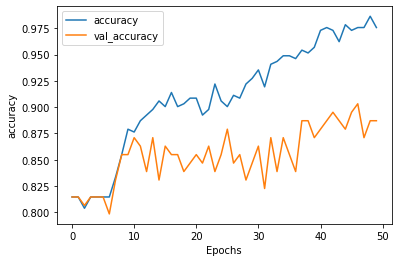

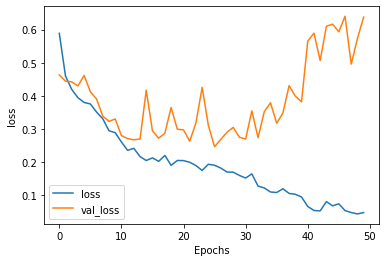

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Gerando arquivos para visualizar o embedding

O snippet abaixo gera dois arquivos que podem ser visualizados se upados em https://projector.tensorflow.org

*TODO*: implementar `projector` de `tensorboard.plugins`

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, weights.shape[0]):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()